In [1]:
import pandas as pd
import os
from keras.utils import img_to_array, load_img
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

# Step 1: Load dataset
df = pd.DataFrame(columns=['imagePath', 'label'])

directories = {
    "ayam_goreng": "./dataset/ayam_goreng/",
    "ayam_pop": "./dataset/ayam_pop/",
    "daging_rendang": "./dataset/daging_rendang/",
    "dendeng_batokok": "./dataset/dendeng_batokok/",
    "gulai_ikan": "./dataset/gulai_ikan/",
    "gulai_tambusu": "./dataset/gulai_tambusu/",
    "telur_balado": "./dataset/telur_balado/",
    "telur_dadar": "./dataset/telur_dadar/",
    "tahu": "./dataset/tahu/",
    "daun_singkong": "./dataset/daun_singkong/",
    "nangka": "./dataset/nangka/",
    "perkedel": "./dataset/perkedel/",
    "nasi" : "./dataset/nasi/"
}

for label, directory in directories.items():
    for i in os.listdir(directory):
        df = pd.concat([df, pd.DataFrame({'imagePath': [f"{directory}/{i}"], 'label': [label]})])

df = df.reset_index(drop=True)

imgs = []
for image_path in df['imagePath']:
    img = load_img(image_path, target_size=(254, 254)).convert('RGB')
    img_array = img_to_array(img)
    imgs.append(img_array)

df['img'] = imgs


le = LabelEncoder()
y = le.fit_transform(df['label'])

x = np.array(df['img'].tolist())
x = preprocess_input(x)
x = x / 255
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    channel_shift_range=20,
    preprocessing_function=lambda img: img + np.random.normal(0, 0.1, img.shape)  # Add Gaussian noise
)
datagen.fit(x_train)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(254, 254, 3))

train_features = base_model.predict(datagen.flow(x_train, batch_size=32, shuffle=False), verbose=1)
test_features = base_model.predict(x_test, verbose=1)

pca = PCA(n_components=100) 
x_train_pca = pca.fit_transform(train_features.reshape(train_features.shape[0], -1))
x_test_pca = pca.transform(test_features.reshape(test_features.shape[0], -1))

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

c:\Users\lenovo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


17/17 [==============================] - 7s 412ms/step


In [2]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train_pca, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

model = RandomForestClassifier(**best_params, random_state=42)
model.fit(x_train_pca, y_train)

y_pred = model.predict(x_test_pca)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [3]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cv_scores = cross_val_score(model, x_train_pca, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Accuracy: 0.12710280373831775
Cross-validation scores: [0.0864486  0.07242991 0.06791569 0.09836066 0.09367681]
Mean cross-validation score: 0.08376633325308061


In [4]:
le.inverse_transform(y_test)

array(['nangka', 'gulai_tambusu', 'telur_dadar', 'telur_dadar',
       'gulai_tambusu', 'nasi', 'gulai_tambusu', 'ayam_goreng', 'nangka',
       'nangka', 'nasi', 'nasi', 'tahu', 'nasi', 'nangka',
       'gulai_tambusu', 'telur_balado', 'daun_singkong',
       'dendeng_batokok', 'ayam_pop', 'gulai_tambusu', 'daging_rendang',
       'nasi', 'gulai_tambusu', 'telur_balado', 'perkedel', 'nangka',
       'telur_dadar', 'telur_dadar', 'daging_rendang', 'gulai_ikan',
       'perkedel', 'telur_balado', 'tahu', 'tahu', 'ayam_goreng', 'nasi',
       'daun_singkong', 'daun_singkong', 'tahu', 'ayam_goreng',
       'ayam_pop', 'daging_rendang', 'ayam_pop', 'ayam_goreng',
       'ayam_pop', 'nasi', 'ayam_pop', 'daun_singkong', 'gulai_ikan',
       'telur_balado', 'perkedel', 'dendeng_batokok', 'daging_rendang',
       'gulai_tambusu', 'perkedel', 'telur_balado', 'tahu',
       'gulai_tambusu', 'telur_dadar', 'nangka', 'nangka',
       'dendeng_batokok', 'dendeng_batokok', 'daun_singkong',
       'd

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


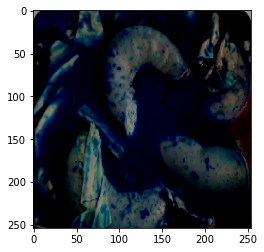

In [5]:
import matplotlib.pyplot as plt

plt.imshow(x_test[15])

In [6]:
x_test_pca[0].shape

(100,)